In [63]:
# !pip install --upgrade networkx scipy

In [64]:
from utils import *
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
from networkx.algorithms.community import girvan_newman
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import qgrid
import ipywidgets as wg
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [65]:
#LOADING THE DATA
dataset_path = 'data/soc-sign-bitcoinotc_v2.csv'
bitcoin_data = pd.read_csv(dataset_path)

print("Dataset Overview:")
print(bitcoin_data.info())

print("\n\nFirst few rows of the dataset:")
print(bitcoin_data.head())

print("\n\nSummary Statistics:")
print(bitcoin_data.describe())
bitcoin_data.head()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #source     35592 non-null  int64 
 1   #target     35592 non-null  int64 
 2   #rating     35592 non-null  int64 
 3   #timestamp  35592 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.1+ MB
None


First few rows of the dataset:
   #source  #target  #rating           #timestamp
0        6        2        4  2010-11-08 18:45:11
1        6        5        2  2010-11-08 18:45:41
2        1       15        1  2010-11-08 19:05:40
3        4        3        7  2010-11-08 19:41:17
4       13       16        8  2010-11-08 22:10:54


Summary Statistics:
            #source       #target       #rating
count  35592.000000  35592.000000  35592.000000
mean    2353.847269   2417.478254      1.012025
std     1605.771178   1658.232170      3.562094
min        1.000000      1.00000

,#source,#target,#rating,#timestamp
0,6,2,4,2010-11-08 18:45:11
1,6,5,2,2010-11-08 18:45:41
2,1,15,1,2010-11-08 19:05:40
3,4,3,7,2010-11-08 19:41:17
4,13,16,8,2010-11-08 22:10:54


DATA PRE-PROCESSING

In [66]:
#CHECKING FOR MISSING VALUES
missing_values = bitcoin_data.isnull().sum()
print("Columns with Missing Values: ")
print(missing_values)

Columns with Missing Values: 
#source       0
#target       0
#rating       0
#timestamp    0
dtype: int64


ANALYZING THE GRAPH

In [67]:
#CREATING A DIRECTED GRAPH
Graph = nx.from_pandas_edgelist(bitcoin_data, '#source', '#target', create_using=nx.DiGraph())

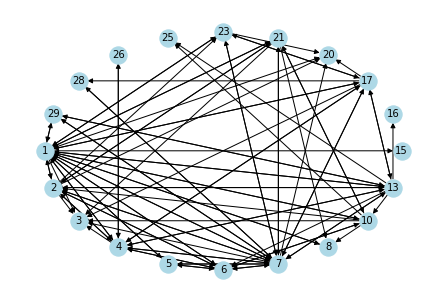

In [68]:
#PLOTTING A SUBGRAPH
subset_nodes = list(Graph.nodes())[:20]  
subset_edges = list(Graph.edges())[:20]  

subgraph = Graph.subgraph(subset_nodes + subset_edges)

pos = nx.shell_layout(subgraph)
node_color = 'lightblue'

nx.draw(subgraph, pos, with_labels=True, font_size=10, node_size=300, node_color=node_color)

plt.show()

In [69]:
largest_scc = max(nx.strongly_connected_components(subgraph), key=len)

#CREATING A SUBGRAPH USING THE STRONGLY CONNECTED COMPONENTS
subgraph_scc = Graph.subgraph(largest_scc)

#CALCULATING THE ADDITIONAL METRICS
average_path_length = nx.average_shortest_path_length(subgraph_scc)
diameter = nx.diameter(subgraph_scc)
transitivity = nx.transitivity(subgraph_scc)

print(f"Average Path Length: {average_path_length}")
print(f"Diameter: {diameter}")
print(f"Transitivity: {transitivity}")

Average Path Length: 1.7095238095238094
Diameter: 3
Transitivity: 0.52


In [70]:
#CALCULATING BASIC STATS OF GRAPH
num_nodes = Graph.number_of_nodes()
num_edges = Graph.number_of_edges()
avg_degree = sum(dict(Graph.degree()).values()) / num_nodes
density = nx.density(Graph)
clustering_coefficient = nx.average_clustering(Graph)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree}")
print(f"Density: {density}")
print(f"Clustering coefficient: {clustering_coefficient}")

Number of nodes: 5881
Number of edges: 35592
Average degree: 12.104063934704982
Density: 0.0010292571373048454
Clustering coefficient: 0.15106980550907195


OUT DEGREE

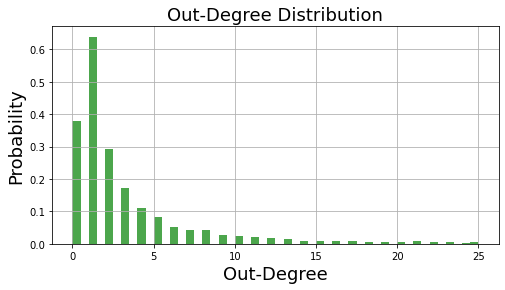

In [71]:
out_degrees = dict(Graph.out_degree())
out_deg_scores = sorted(list(out_degrees.values()))
x_range = (0, 25)
# Plotting out-degree distribution
plt.figure(figsize=(8, 4))
plt.hist(out_deg_scores, bins=50, color='green',range=x_range, alpha=0.7, density=True)
plt.xlabel('Out-Degree', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.title('Out-Degree Distribution', fontsize=18)
plt.grid(True)
plt.show()


IN DEGREE

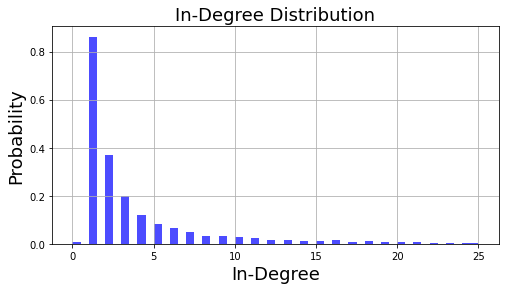

In [72]:
# Calculate in-degrees
in_degrees = dict(Graph.in_degree())
in_deg_scores = sorted(list(in_degrees.values()))
x_range = (0, 25)
# Plotting in-degree distribution
plt.figure(figsize=(8, 4))
plt.hist(in_deg_scores, bins=50, color='blue',range=x_range, alpha=0.7, density=True)
plt.xlabel('In-Degree', fontsize=18)
plt.ylabel('Probability', fontsize=18)
plt.title('In-Degree Distribution', fontsize=18)
plt.grid(True)
plt.show()

DISTRIBUTION OF OUT DEGREE & RATING

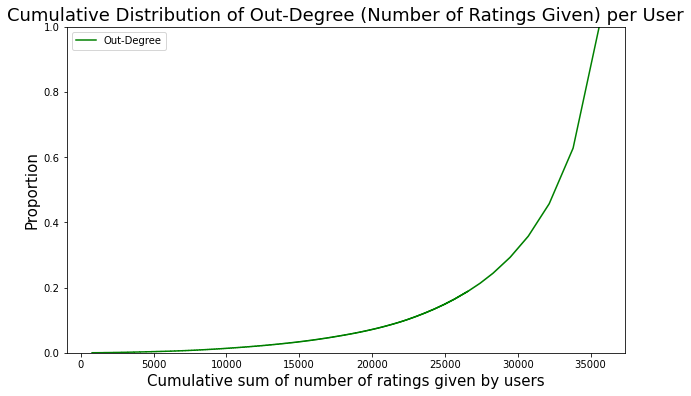

In [73]:
# Count the number of ratings given by each user (out-degree)
out_degree_count = bitcoin_data.groupby('#source')['#rating'].count()

# Calculate cumulative sum of out-degrees per user
cumulative_out_degree = out_degree_count.sort_values(ascending=False).cumsum()

# Create an empirical cumulative distribution plot for out-degrees
plt.figure(figsize=(10, 6))
ax = sns.ecdfplot(cumulative_out_degree, color='green', label='Out-Degree')
plt.xlabel('Cumulative sum of number of ratings given by users', fontsize=15)
plt.ylabel('Proportion', fontsize=15)
plt.title('Cumulative Distribution of Out-Degree (Number of Ratings Given) per User', fontsize=18)
plt.legend()
plt.show()



In [74]:
print(f'70 percent of users have received less than {int(np.percentile(out_degree_count, 70))} ratings')

70 percent of users have received less than 4 ratings


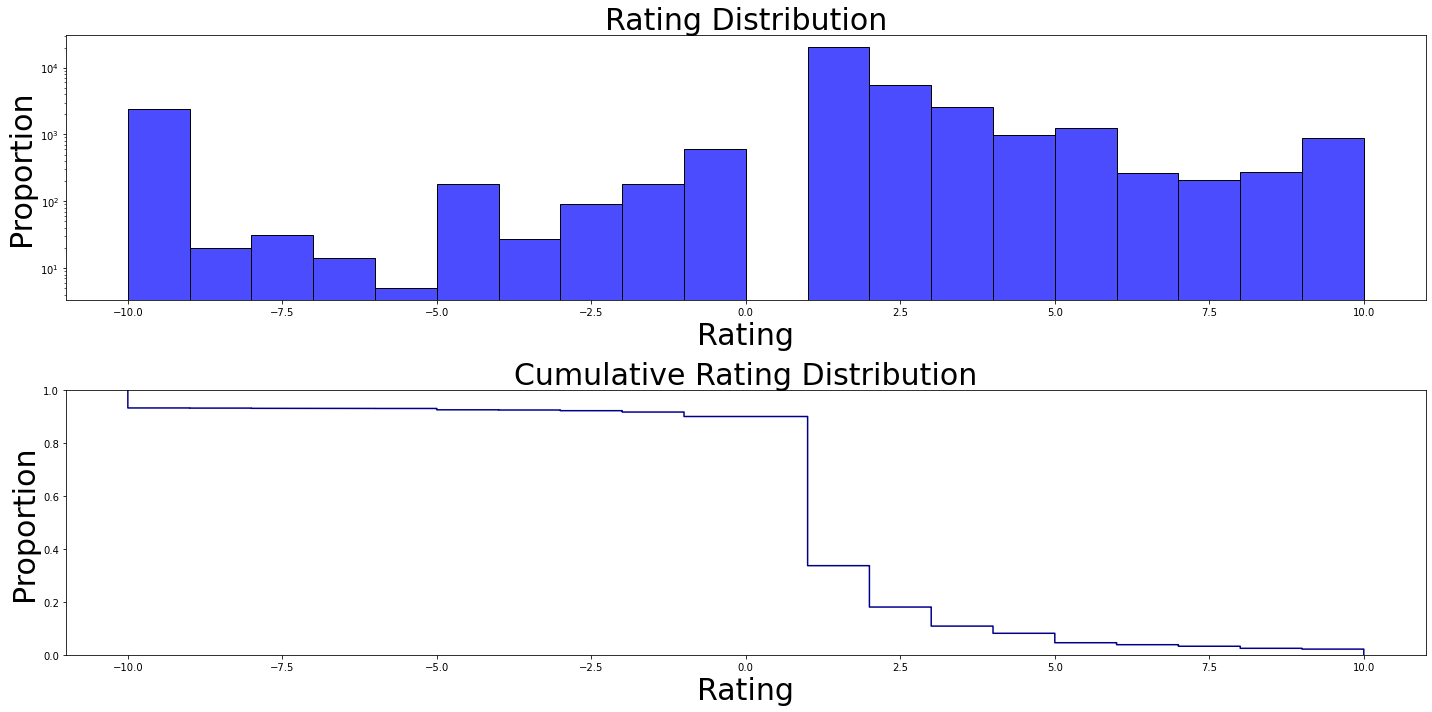

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Extract ratings from the DataFrame
ratings = bitcoin_data['#rating']

# Plot histogram
sns.histplot(ratings, bins=20, color='blue', alpha=0.7, log_scale=(False, True), ax=axes[0])
axes[0].set_ylabel('Proportion', fontsize=30)
axes[0].set_title('Rating Distribution', fontsize=30)
axes[0].set_xlabel('Rating', fontsize=30)

# ECDF plot
sns.ecdfplot(data=ratings, ax=axes[1], color='darkblue', complementary=True)
axes[1].set_xlabel('Rating', fontsize=30)
axes[1].set_ylabel('Proportion', fontsize=30)
axes[1].set_title('Cumulative Rating Distribution', fontsize=30)

fig.tight_layout()
plt.show()


In [76]:
in_deg = [deg for node, deg in dict(Graph.in_degree()).items()]
out_deg = [deg for node, deg in dict(Graph.out_degree()).items()]

SCATTER PLOT BELOW SHOWS THE POSITIVE CORRELATION BETWEEN IN-DEGREE AND OUT-DEGREE

Text(0, 0.5, 'Out Degree')

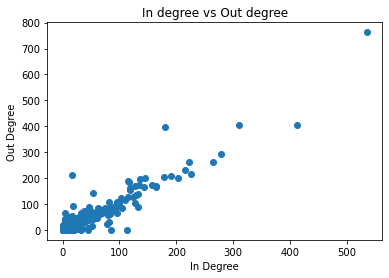

In [77]:
plt.scatter(in_deg, out_deg)
plt.title('In degree vs Out degree')
plt.xlabel('In Degree')
plt.ylabel('Out Degree')


DEGREE CENTRALITY

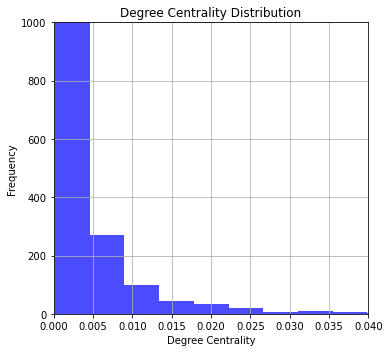

In [78]:
degree_centrality = nx.degree_centrality(Graph)
centrality_values = list(degree_centrality.values())

plt.figure(figsize=(15, 5))


# ZOOMED IN VERSION
plt.subplot(1, 3, 2)
plt.hist(centrality_values, bins=50, color='blue', alpha=0.7)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 0.04)  
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()


BETWEENNESS CENTRALITY

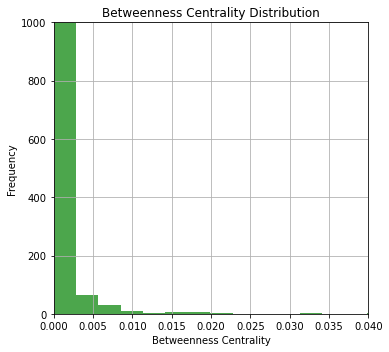

In [79]:
betweenness_centrality = nx.betweenness_centrality(Graph)

plt.figure(figsize=(15, 5))
#BETWEENESS CENTRALITY
plt.subplot(1, 3, 2)
plt.hist(list(betweenness_centrality.values()), bins=50, color='green', alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 0.04) 
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()

EIGENVECTOR CENTRALITY

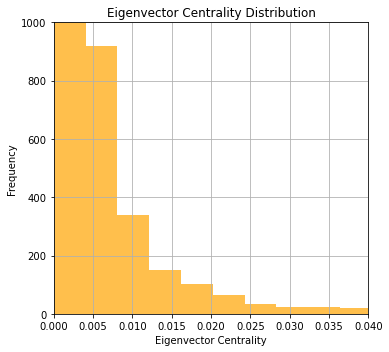

In [80]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(Graph)
#EIGENVECTOR CENTRALITY
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
plt.hist(list(eigenvector_centrality.values()), bins=50, color='orange', alpha=0.7)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0, 0.04)
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()

ANALYSING THE BETWORK BASED ON TIMESTAMP

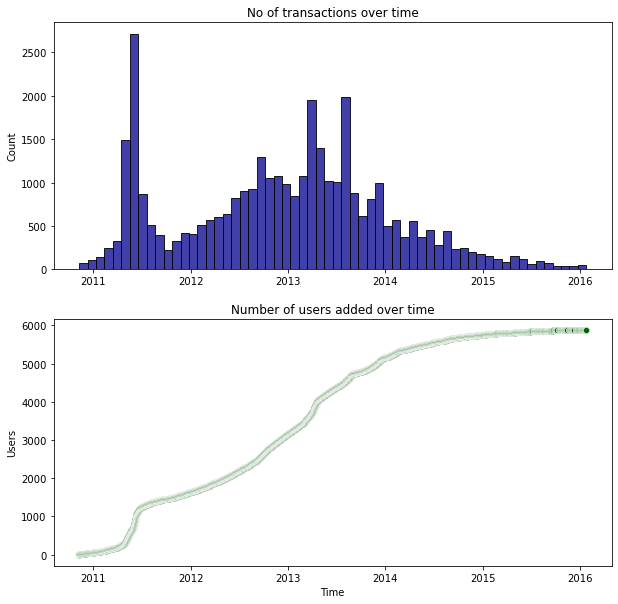

In [81]:
def str_to_date(date_str):
    if isinstance(date_str, str):
        return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    else:
        return None
# Adding edges to the graph from the DataFrame
for index, row in bitcoin_data.iterrows():
    source = row['#source']
    target = row['#target']
    rating = row['#rating']
    timestamp = row['#timestamp']
    Graph.add_edge(source, target, rating=rating, timestamp=timestamp)

# Plotting the graph
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

#transactions over time
edges = [(node1, node2, str_to_date(attr['timestamp'])) for node1, node2, attr in Graph.edges(data=True) if 'timestamp' in attr]
edges_sort_by_time = sorted(edges, key=lambda x: x[2])
time_stamps = [x[2] for x in edges_sort_by_time]
ax = sns.histplot(time_stamps, color='darkblue', ax=axes[0])
_ = ax.set_title('No of transactions over time')

# Plotting the number of users added over time
nodes = set()
nodes_over_time = []
for node1, node2, time in edges_sort_by_time:
    nodes.update((node1, node2))
    nodes_over_time.append((time, len(nodes)))
time, num_users = zip(*nodes_over_time)
ax = sns.scatterplot(time, num_users, color='darkgreen', ax=axes[1])
ax.set_title('Number of users added over time')
ax.set_xlabel('Time')
_ = ax.set_ylabel('Users')


In [83]:
G = nx.read_edgelist('data/soc-sign-bitcoinotc_v2.csv', delimiter=',', nodetype=int,
                  data = (('rating', int), ('time', str)), 
                  create_using=nx.DiGraph)

COMMUNITIES DETECTED FROM GEPHI TOOL

In [84]:
import pandas as pd
import networkx as nx

gephi = pd.read_csv('gephi_bitcoin.csv')

for index, row in gephi.iterrows():
    G.add_node(row['Id'], modularity_class=row['modularity_class'])

modularity_class = nx.get_node_attributes(G, 'modularity_class')

communities = {}
for node, mod_class in modularity_class.items():
    if mod_class not in communities:
        communities[mod_class] = [node]
    else:
        communities[mod_class].append(node)

for mod_class, nodes in communities.items():
    print(f'Community {mod_class}: {nodes}')


Community 4.0: [6, 2, 5, 1, 15, 4, 3, 10, 7, 21, 20, 8, 17, 23, 28, 29, 31, 32, 34, 36, 37, 44, 39, 45, 19, 46, 47, 52, 53, 54, 41, 55, 61, 56, 66, 69, 71, 72, 74, 75, 68, 64, 76, 77, 78, 60, 80, 81, 62, 83, 104, 86, 87, 89, 94, 97, 99, 88, 101, 100, 103, 105, 108, 109, 110, 111, 112, 115, 114, 119, 122, 127, 129, 116, 131, 132, 113, 125, 135, 134, 137, 138, 140, 141, 139, 142, 143, 144, 145, 147, 148, 93, 149, 150, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 165, 166, 167, 168, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 159, 182, 183, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 120, 211, 212, 213, 214, 216, 217, 218, 219, 220, 223, 224, 225, 227, 228, 231, 232, 233, 208, 234, 235, 222, 236, 237, 238, 239, 240, 241, 244, 164, 245, 247, 248, 250, 251, 249, 243, 252, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 268, 229, 221, 269, 271, 272, 273, 274, 275, 276, 270, 277, 279, 278, 282, 

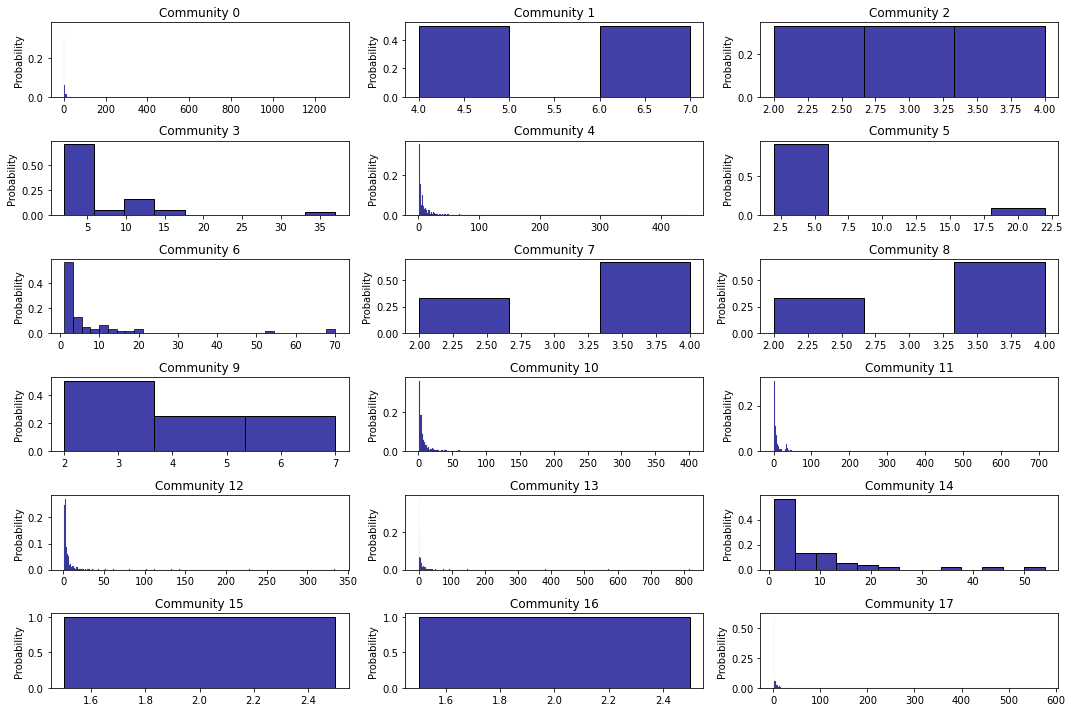

In [85]:
fig, ax = plt.subplots(6, 3, figsize=(15, 10))

def plot_degree_dist(G, ax, ind):
    degree = dict(G.degree())  
    subgraph_nodes = communities[ind]  # Use nodes from the specific community
    sorted_degrees = sorted((n, degree[n]) for n in subgraph_nodes)
    deg_scores = [x[1] for x in sorted_degrees]
    
    if not ax:
        fig, ax = plt.subplots(figsize=(20, 10))
    plt_ = sns.histplot(deg_scores, stat='probability', color='darkblue', ax=ax)
    plt_.axes.set_xscale('linear')
    plt_.axes.set_yscale('linear')
    
    ax.set_title(f'Community {ind}')

ind = 0
for i in range(6):
    for j in range(3):
        plot_degree_dist(G, ax[i][j], ind=ind)
        ind += 1

fig.tight_layout()
plt.show()

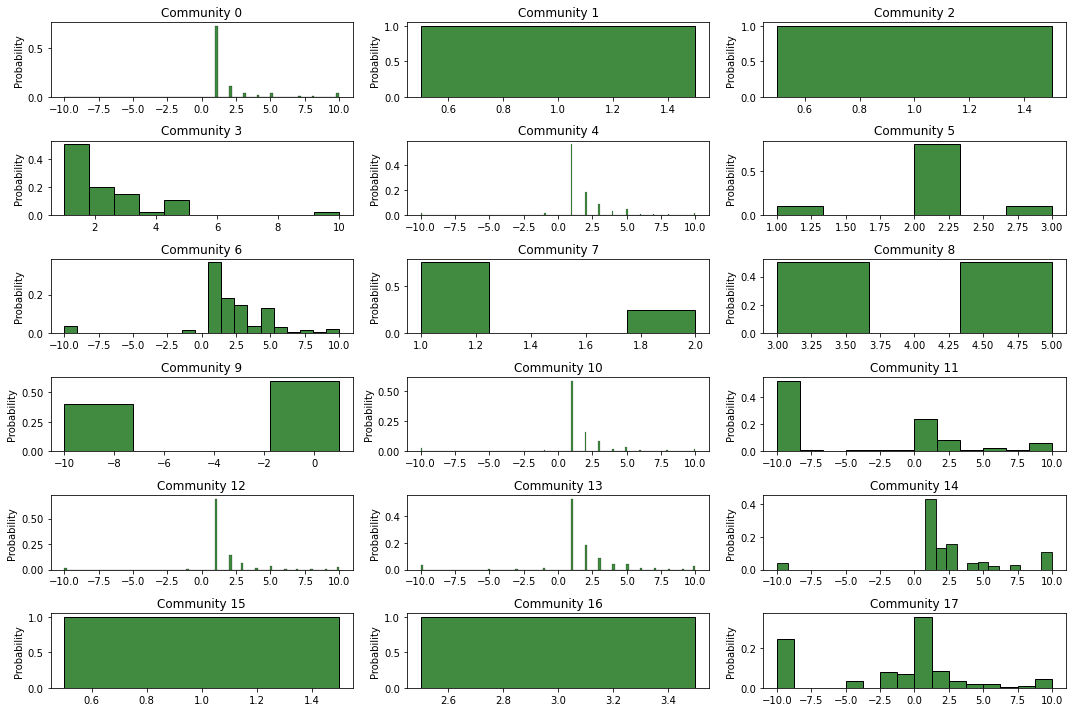

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(6, 3, figsize=(15, 10))

ind = 0

for i in range(6):
    for j in range(3):
        subgraph_nodes = communities[ind]
        G_sub = G.subgraph(subgraph_nodes)
        ratings = [G_sub.get_edge_data(*edge)['rating'] for edge in G_sub.edges()]
        plt_ = sns.histplot(ratings, stat='probability', color='darkgreen', ax=ax[i][j])
        plt_.axes.set_xscale('linear')
        plt_.axes.set_yscale('linear')

        ax[i][j].set_title(f'Community {ind}')
        ind += 1

fig.tight_layout()
plt.show()


In [87]:
for node in G.nodes():
    in_ratings = [(v, G.get_edge_data(u, v)['rating']) for u, v in G.in_edges(node)]
    out_ratings = [(v, G.get_edge_data(node, v)['rating']) for v in G.successors(node)]
    
    G.nodes[node]['in_rating_category'] = 1 if all(edge_attr >= 0 for _, edge_attr in in_ratings) else -1 if all(edge_attr < 0 for _, edge_attr in in_ratings) else 0
    G.nodes[node]['out_rating_category'] = 1 if all(edge_attr >= 0 for _, edge_attr in out_ratings) else -1 if all(edge_attr < 0 for _, edge_attr in out_ratings) else 0
    G.nodes[node]['num_in_ratings'] = len(in_ratings)
    G.nodes[node]['num_out_ratings'] = len(out_ratings)

in_pos_nodes = [x for x, y in G.nodes(data=True) if y['in_rating_category'] == 1 and y['num_in_ratings'] >= 5]
in_neg_nodes = [x for x, y in G.nodes(data=True) if y['in_rating_category'] == -1 and y['num_in_ratings'] >= 5]
in_mix_nodes = [x for x, y in G.nodes(data=True) if y['in_rating_category'] == 0 and y['num_in_ratings'] >= 5]

out_pos_nodes = [x for x, y in G.nodes(data=True) if y['out_rating_category'] == 1 and y['num_out_ratings'] >= 5]
out_neg_nodes = [x for x, y in G.nodes(data=True) if y['out_rating_category'] == -1 and y['num_out_ratings'] >= 5]
out_mix_nodes = [x for x, y in G.nodes(data=True) if y['out_rating_category'] == 0 and y['num_out_ratings'] >= 5]

print('Nodes with positive in ratings: ', len(in_pos_nodes))
print('Nodes with negative in ratings: ', len(in_neg_nodes))
print('Nodes with a mix of in ratings: ', len(in_mix_nodes))
print('\n')
print('Nodes with positive out ratings: ', len(out_pos_nodes))
print('Nodes with negative out ratings: ', len(out_neg_nodes))
print('Nodes with a mix of out ratings: ', len(out_mix_nodes))


Nodes with positive in ratings:  848
Nodes with negative in ratings:  20
Nodes with a mix of in ratings:  621


Nodes with positive out ratings:  851
Nodes with negative out ratings:  13
Nodes with a mix of out ratings:  546


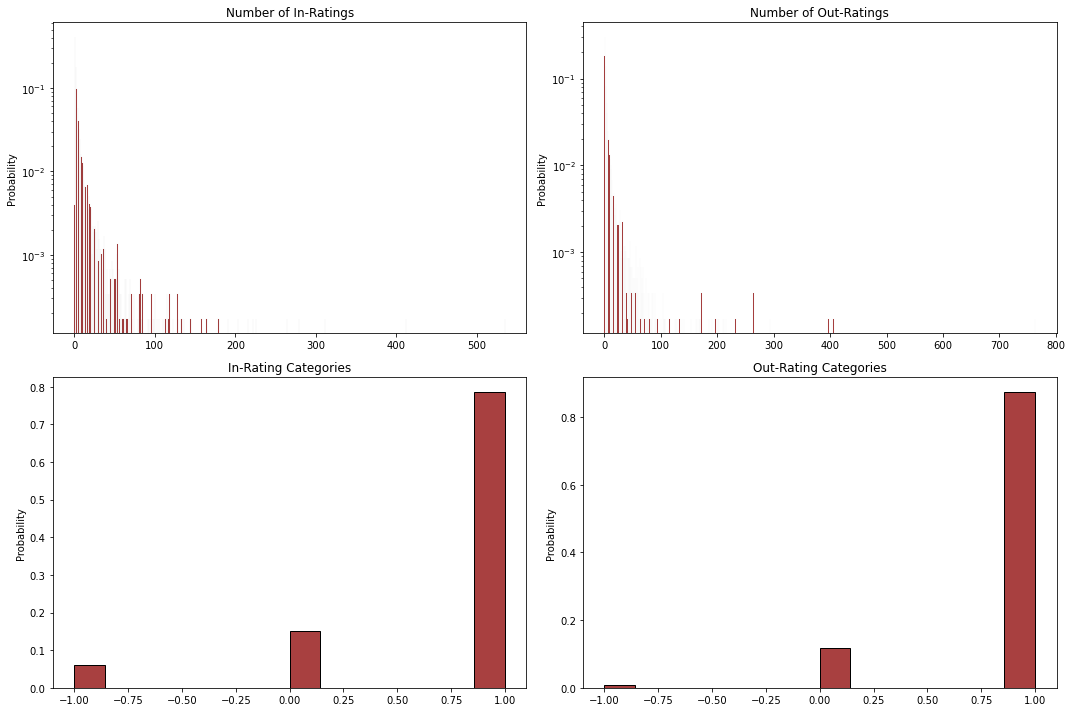

In [88]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# histogram for the number of in-ratings
plt_ = sns.histplot([y['num_in_ratings'] for x, y in G.nodes(data=True)], stat='probability', color='darkred', ax=ax[0, 0])
plt_.axes.set_yscale('log')
ax[0, 0].set_title('Number of In-Ratings')

#histogram for the number of out-ratings
plt_ = sns.histplot([y['num_out_ratings'] for x, y in G.nodes(data=True)], stat='probability', color='darkred', ax=ax[0, 1])
plt_.axes.set_yscale('log')
ax[0, 1].set_title('Number of Out-Ratings')

#histogram for in-rating categories
plt_ = sns.histplot([y['in_rating_category'] for x, y in G.nodes(data=True)], stat='probability', color='darkred', ax=ax[1, 0])
ax[1, 0].set_title('In-Rating Categories')

#histogram for out-rating categories
plt_ = sns.histplot([y['out_rating_category'] for x, y in G.nodes(data=True)], stat='probability', color='darkred', ax=ax[1, 1])
ax[1, 1].set_title('Out-Rating Categories')

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'All Negative Out-Ratings')

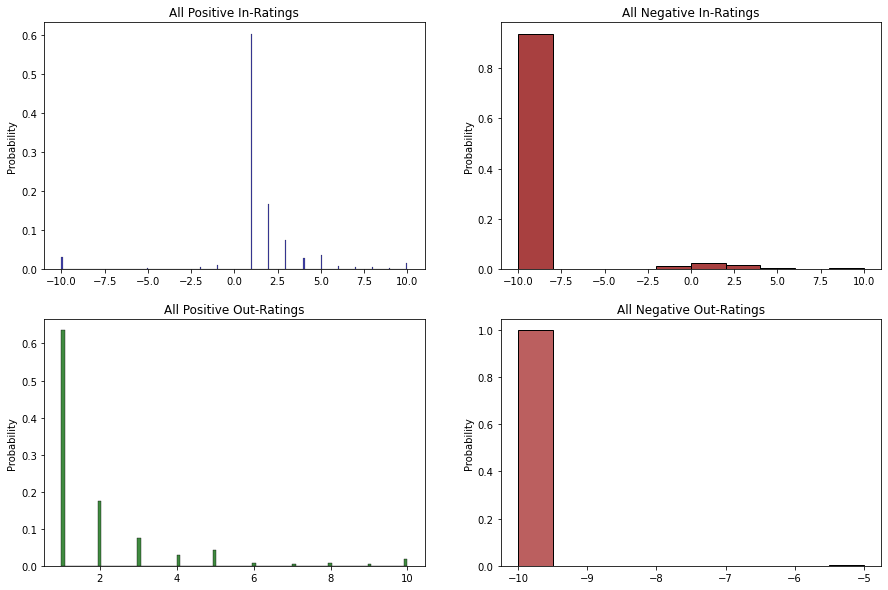

In [89]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt_ = sns.histplot([G.get_edge_data(u, v)['rating'] for u in in_pos_nodes for v in G.successors(u)], stat='probability', color='darkblue', ax=ax[0, 0])
ax[0, 0].set_title('All Positive In-Ratings')
plt_ = sns.histplot([G.get_edge_data(u, v)['rating'] for u in in_neg_nodes for v in G.successors(u)], stat='probability', color='darkred', ax=ax[0, 1])
ax[0, 1].set_title('All Negative In-Ratings')
plt_ = sns.histplot([G.get_edge_data(u, v)['rating'] for u in out_pos_nodes for v in G.successors(u)], stat='probability', color='darkgreen', ax=ax[1, 0])
ax[1, 0].set_title('All Positive Out-Ratings')
plt_ = sns.histplot([G.get_edge_data(u, v)['rating'] for u in out_neg_nodes for v in G.successors(u)], stat='probability', color='brown', ax=ax[1, 1])
ax[1, 1].set_title('All Negative Out-Ratings')